#**Universidad Galileo**
##Statistical Learning II - Proyecto Convolutional Neural Network
###César Luis Polanco
###20062088

# Clasificación de enfermedades a través de Redes Neuronales Convolucionals
<br>

## Contexto

Durante el curso de Introducción a la investigación se tuvo como entragble la presentación de un poster de un tema que fuera de interés. La investigación que tuvo más interés fue el tema de visión por computadora específicamente en el apoyo a la identificación de enfermedades en las plantas.

## Objetivo
Para esta parte del proyecto se estará realizando una red neuronal convolucional con el objetivo de poder identificar enfermedades de manera oportuna en las plantas. Este tipo de proyectos busca ayuadar a los cientos de agricultores que no tienen los recursos necesarios para contratar los servicios de un experto en materia que identifique y trate las plantas en peligro.

In [ ]:
#Cargar libreria
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
import seaborn as sns
from keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras import layers
from keras.models import Model
import matplotlib.pyplot as plt
import datetime
import os
import random
import cv2
from sklearn import preprocessing
from tqdm import tqdm
from collections import Counter

In [ ]:
#Mount Gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dir =  '/content/drive/MyDrive/SL2/CNN'
dir_img = '/content/drive/MyDrive/SL2/CNN/img'
dir_checkpoint = os.path.dirname('/content/drive/MyDrive/SL2/CNN/checkpoint')
os.chdir( dir)

## División de imágenes

In [ ]:
#Comentado por pruebas
#splitfolders.ratio(dir_img, output='splitted', seed=2022, ratio=(0.6,0.2, 0.2))

In [ ]:
train_model_dir = '/content/drive/MyDrive/SL2/CNN/model_train'
test_model_dir = '/content/drive/MyDrive/SL2/CNN/model_test'
train_dir = '/content/drive/MyDrive/SL2/CNN/splitted/train'
val_dir = '/content/drive/MyDrive/SL2/CNN/splitted/val'
test_dir = '/content/drive/MyDrive/SL2/CNN/splitted/test'

## Dataset Train , Test y Validation

### Parámetros

In [ ]:
batch_size = 32
size = 224
img_size=(size,size)
shape = (size, size, 3)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=None,
  seed=1010,
  image_size=(size, size), #efficientNetB2
  batch_size=batch_size)

Found 3348 files belonging to 4 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  validation_split=None,
  seed=1010,
  image_size=(size, size), #efficientNetB2
  batch_size=batch_size)

Found 836 files belonging to 4 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=None,
  seed=1010,
  image_size=(size, size), #efficientNetB2
  batch_size=batch_size)


Found 3348 files belonging to 4 classes.


## Identificación de Clases

In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(num_classes)

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
4


## Muestra de datos Train

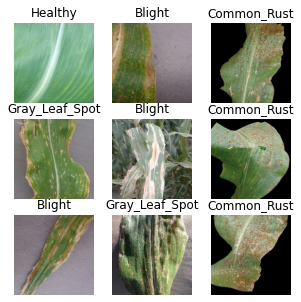

In [ ]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(-(-9//3), 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])

## Image Augmentation

In [ ]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(size,size,3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3)
  ]
)

## Checkpoint para callbacks

In [ ]:
checkpoint = ModelCheckpoint(filepath=dir_checkpoint,
                             monitor = 'val_accuracy',
                             verbose=1, 
                             save_best_only=True,)

## Definición Modelo

In [ ]:
model = Sequential([
                      data_augmentation,
                      tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
                      Conv2D(32, 3, padding='same', activation='relu'),
                      MaxPool2D(),
                      Conv2D(32, 3, padding='same', activation='relu'),
                      MaxPool2D(),
                      Dropout(0.4),
                      Conv2D(64, 3, padding='same', activation='relu'),
                      MaxPool2D(),
                      Dropout(0.4),
                      Flatten(),
                      Dense(128, activation='relu'),
                      Dense(num_classes)
  ])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

## Compilar Modelo 

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Entrenar modelo

Dada la cantidad de imágenes y el tiempo que se demora, se utilizó únicamente (5 y 10) épocas.

In [ ]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    callbacks = [checkpoint]
)

Epoch 1/10
105/105 [==============================] - ETA: 0s - loss: 0.9198 - accuracy: 0.6380
Epoch 1: val_accuracy improved from -inf to 0.80981, saving model to /content/drive/MyDrive/SL2/CNN
105/105 [==============================] - 509s 5s/step - loss: 0.9198 - accuracy: 0.6380 - val_loss: 0.6323 - val_accuracy: 0.8098
Epoch 2/10
105/105 [==============================] - ETA: 0s - loss: 0.5752 - accuracy: 0.7649
Epoch 2: val_accuracy improved from 0.80981 to 0.81579, saving model to /content/drive/MyDrive/SL2/CNN
105/105 [==============================] - 268s 3s/step - loss: 0.5752 - accuracy: 0.7649 - val_loss: 0.5197 - val_accuracy: 0.8158
Epoch 3/10
105/105 [==============================] - ETA: 0s - loss: 0.4851 - accuracy: 0.8011
Epoch 3: val_accuracy improved from 0.81579 to 0.82177, saving model to /content/drive/MyDrive/SL2/CNN
105/105 [==============================] - 273s 3s/step - loss: 0.4851 - accuracy: 0.8011 - val_loss: 0.4678 - val_accuracy: 0.8218
Epoch 4/10

## Guardar modelo con mejor performance

In [ ]:
model.save(dir+'CNN_Model')

## Cargar el mejor rendimiento

In [ ]:
model.load_weights(dir+'CNN_Model')

## Graficar modelo

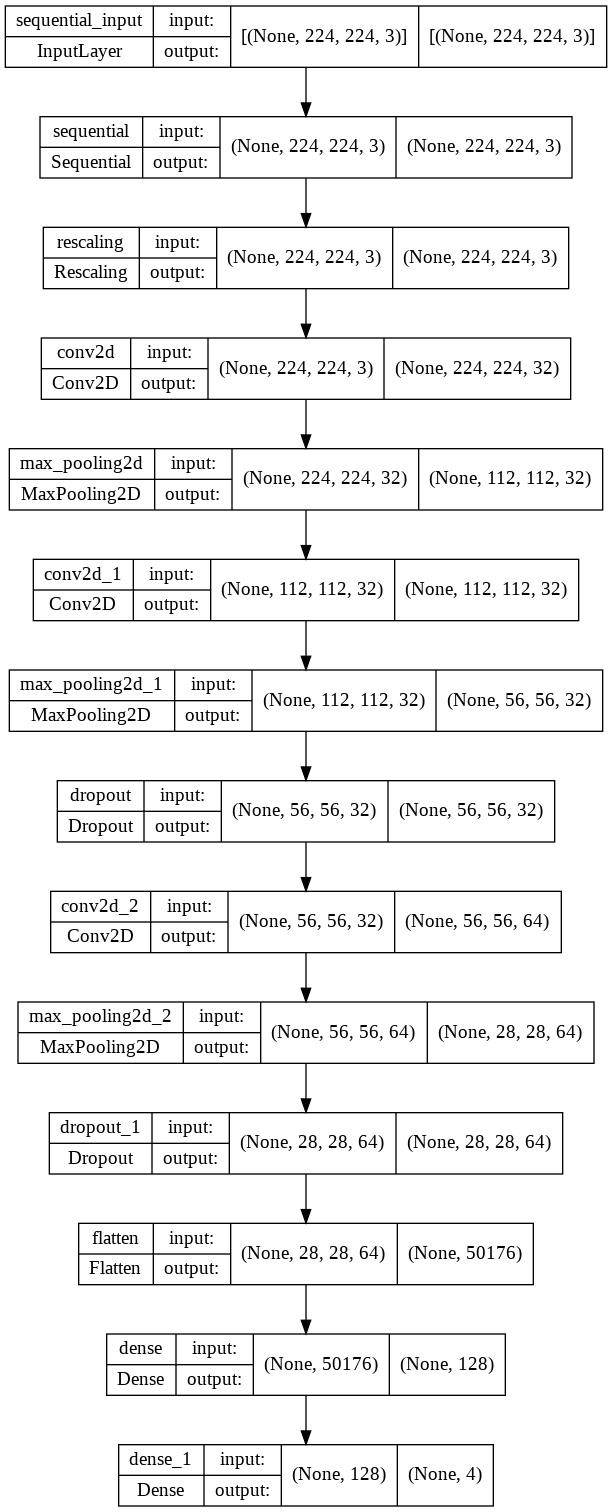

In [ ]:
tf.keras.utils.plot_model(model, to_file="CNN_Model.jpg", show_shapes=True)

## Evaluar modelo 

In [ ]:
#5 épocas
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

105/105 - 1104s - loss: 0.4684 - accuracy: 0.7643 - 1104s/epoch - 11s/step
Restored model, accuracy: 76.43%


In [ ]:
#10 épocas
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

105/105 - 63s - loss: 0.4926 - accuracy: 0.7981 - 63s/epoch - 605ms/step
Restored model, accuracy: 79.81%


## Graficas Loss y Accuracy (5 épocas)

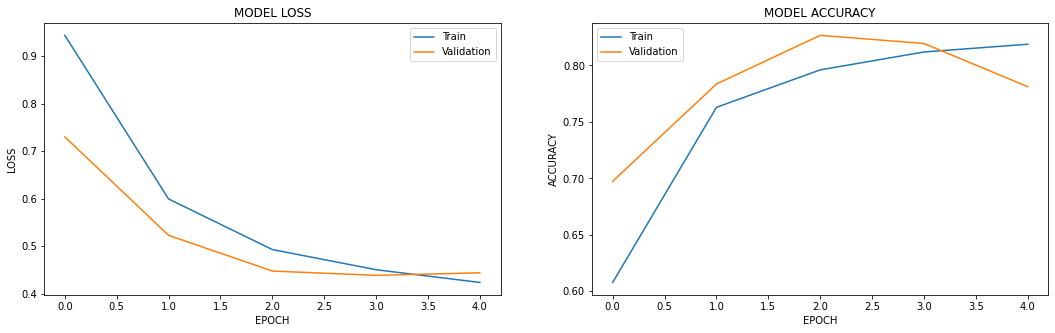

In [ ]:
plt.figure(figsize=(18, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Predicciones con 5 épocas

In [ ]:
labels_pred = np.argmax(model.predict(test_ds), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


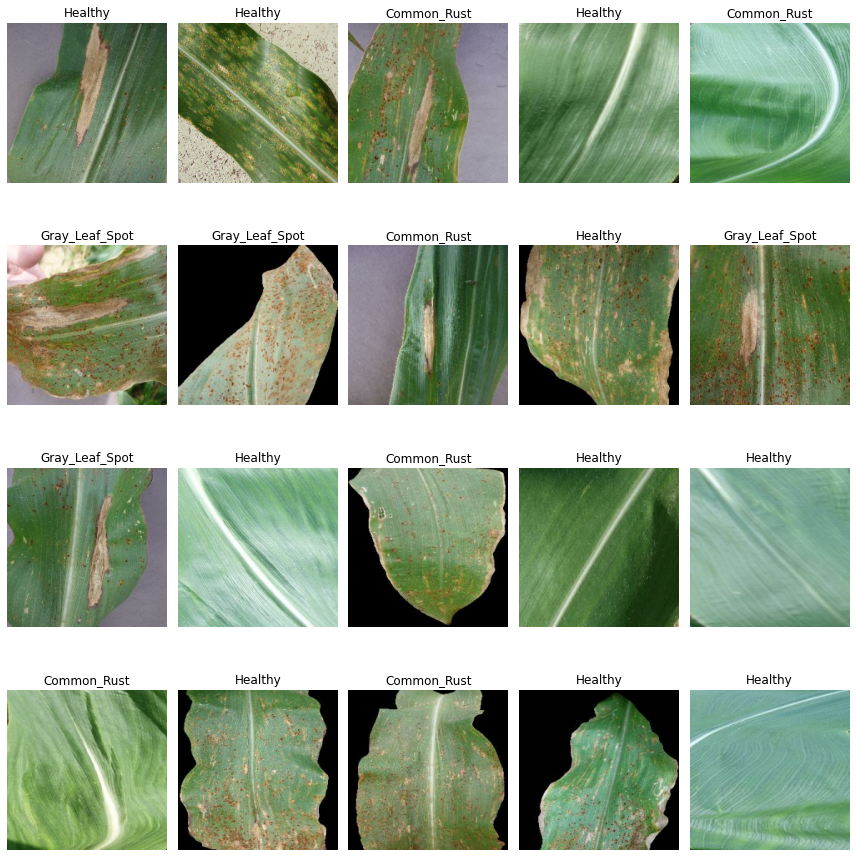

In [ ]:
n = 20

plt.figure(figsize=(12,12))
for images, labels in test_ds.take(-1):
  for i in range(n):
    ax = plt.subplot(-(-n//5),3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels_pred[i]])
    plt.tight_layout(h_pad=5)
    plt.axis("off")

## Gráfica de capas intermedias

In [ ]:
layer_outputs = [layer.output for layer in model.layers[1:10]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(test_ds.take(1)) # Predicción con capas de activación

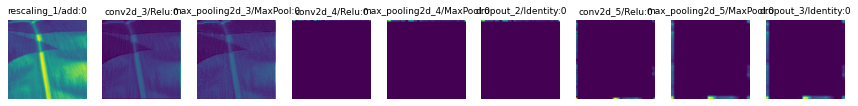

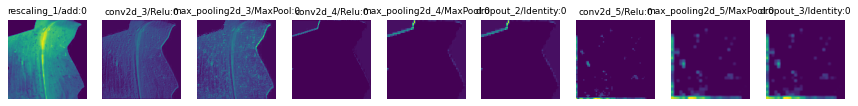

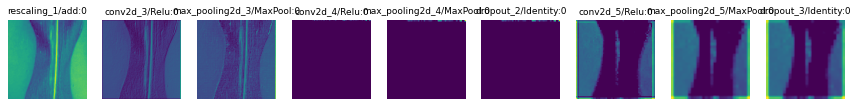

In [ ]:
for i in range(3):
  plt.figure(figsize=(15, 15))
  for j, activation in enumerate(activations):
    plt.subplot(i+1, 9, j+1)
    plt.imshow(activation[i, :, :, 2])
    plt.title(layer_outputs[j].name, fontdict={"fontsize":9, "color":"black"})
    plt.axis("off")
  plt.show()

## Graficas Loss y Accuracy 10 épocas

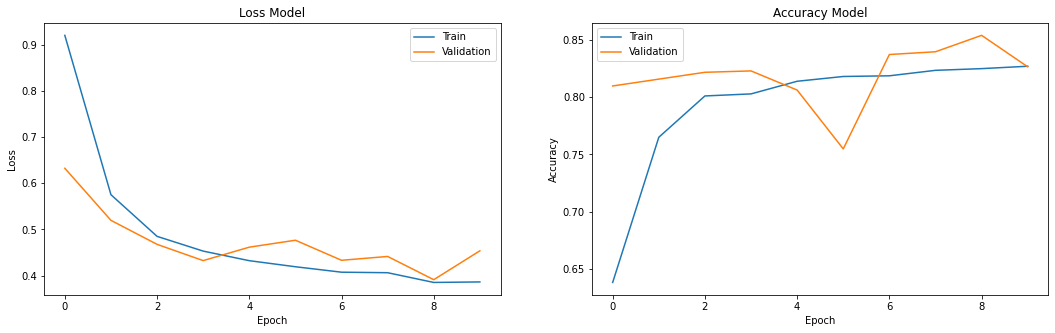

In [ ]:
plt.figure(figsize=(18, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Gráfica de ACCURACY
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Predicciones 10 épocas

In [ ]:
labels_pred = np.argmax(model.predict(test_ds), axis=1)

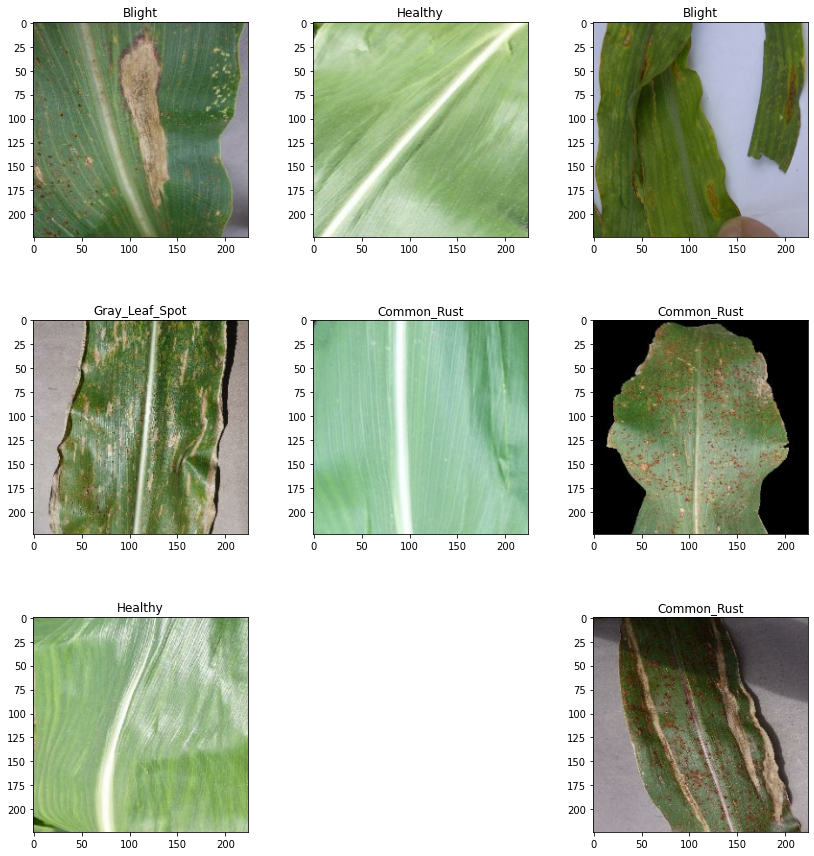

In [ ]:
n = 9
plt.figure(figsize=(12,12))
for images, labels in test_ds.take(1):
  for i in range(n):
    ax = plt.subplot(-(-n//3),3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels_pred[i]])
    plt.tight_layout(h_pad=5)

## Conclusiones del proyecto

Durante el desarrollo del proyecto se pudo evidencias que el procesamiento de imágenes a pesar de ser una tarea (ahora) relativamente sencilla necesita mucho tiempo computacional. 

Con tan solo 10 épocas se obtuvo una precisión de validación del 85% con el que las predicciones a pesar de exisitir un gran gap en el error se considera un buen modelo y permitirá la identificación de enfermedades en plantas.

**trabajo futuro: ** considero que se podría emplear los modelos pre entrenados y EfficentNet para poder mejorar el modelo.

Adicional, tomando en consideración lo aprendido en otros cursos, cada segundo a nivel de procesamiento computacional es **mucho tiempo**

